In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse as sps
import scipy.optimize as optimization
import seaborn as sns

from matplotlib.widgets import Button, Slider

from numba import njit

#%matplotlib inline
%matplotlib widget

In [2]:
@njit()
def diagonalization(Hmat):
  val, vec = np.linalg.eigh(Hmat)
  return val, vec

In [3]:
class Hamiltonian():
  """ In short words, this class is an object that each method will be a characteristic of the Hamiltonian."""
  def __init__(self, hcom, length:int, Jcom, kappacom, PBC:bool, Jres = 1., kappares = 1., hres = 1., Jn = None, kappan = None):
    """
    This will set all the parameters, is also possible to define a not constant J, even if the values for J is not defined this will filled the rest values with Jres.
    Similiar behavior for kappa.
    One can set J_n and kappa_n but if is not defined this will choose the last value of J (depends of how one have defined Jcom and Jres). 
    """
    self.L = length
    self.PBC = PBC
        
    if np.array(hcom).size == 1 :
      self.h = np.ones(self.L)*hcom
    else:
      self.h = np.concatenate((hcom,np.ones(self.L-hcom.shape[0])*hres))
    
    if np.array(Jcom).size == 1 :
      self.J = np.ones(self.L)*Jcom
    else:
      self.J = np.concatenate((Jcom,np.ones(self.L-Jcom.shape[0])*Jres))
    
    if Jn == None :
      self.Jn = self.J[-1]
    else:
      self.Jn = Jn
    
    if np.array(kappacom).size == 1 :
      self.k = np.ones(self.L)*kappacom
    else:
      self.k = np.concatenate((kappacom,np.ones(self.L-kappacom.shape[0])*kappares))
    
    if kappan == None :
      self.kn = self.k[-1]
    else:
      self.kn = kappan
    
    
  def __zero_subspace(self, eigsystem, eps=10**(-4)):
    """
    This is a private method that fixes the eigenvectors of zero eigenvalues.
    """

    size = eigsystem[0].shape[0] #this returns number of eigenvalues
    zeros= eigsystem[0][np.abs(eigsystem[0]) <= eps]
    
    if len(zeros)<1:
        return eigsystem[1].T
    
    zeroindex = [int(size/2)-1,int(size/2)]
    vectors = eigsystem[1].T
    zeroeigenv=[vectors[i] for i in zeroindex]

    if(len(zeroeigenv))!=2:
        print("Alert!, there is no double degeneracy:"+str(len(zeroeigenv)))
        return
    a,b = np.zeros(size), np.zeros(size)

    for i in range(2):
        a += zeroeigenv[i] + np.concatenate((zeroeigenv[i][int(size/2):],zeroeigenv[i][:int(size/2)]))
        b += (-1)**(i)*np.concatenate((zeroeigenv[i][int(size/2):],zeroeigenv[i][:int(size/2)])) + (-1)**(i+1)*zeroeigenv[i]

    a = a/np.linalg.norm(a)
    b = b/np.linalg.norm(b)
    #print("Zero indexes",zeroindex,"a,b",a,b)

    vectors[zeroindex[0]] = (a+b)/np.sqrt(2)
    vectors[zeroindex[1]] = (a-b)/np.sqrt(2)
    return vectors
 
  def matrix(self):
    """
    One has to be careful in this part because if PBC is true then this returns a lambda function object. matrix()(p) where
    for each p one obtains the parity, but in PBC False this return only one matrix. The shape of each matrix (in PBC after lambda function) is 2L x 2L
    """
    
    TL = sps.csr_matrix(np.array([[1,0],[0,0]]))
    TR = sps.csr_matrix(np.array([[0,1],[0,0]]))
    BL = sps.csr_matrix(np.array([[0,0],[1,0]]))
    BR = sps.csr_matrix(np.array([[0,0],[0,1]]))

    A = sps.dok_matrix((self.L,self.L),dtype=np.float32)
    A.setdiag(self.h)
    A.setdiag(-self.J/2, k = 1)
    A.setdiag(-self.J/2, k = -1)

    B = sps.dok_matrix((self.L,self.L),dtype=np.float32)
    B.setdiag(-self.k*self.J/2, k = 1)
    B.setdiag(self.k*self.J/2, k = -1)

    if self.PBC:
      H = np.zeros((2, 2*self.L, 2*self.L))
      for p in range(2):
          A.setdiag(((-1)**p)*self.Jn/2, k=self.L-1)
          A.setdiag(((-1)**p)*self.Jn/2, k=1-self.L)
          B.setdiag(-((-1)**p)*self.kn*self.Jn/2, k=self.L-1)
          B.setdiag(((-1)**p)*self.kn*self.Jn/2, k=1-self.L)
          H[p] = (sps.kron(TL, A) + sps.kron(TR, B) + sps.kron(BL, -B) + sps.kron(BR, -A)).toarray()
      Hmat = lambda x: H[x]
    else:
      Hmat = sps.kron(TL, A) + sps.kron(TR, B) + sps.kron(BL, -B) + sps.kron(BR, -A)
      Hmat = Hmat.toarray()
    return Hmat
  
  def eigensystem(self):
    """
    Generates the eigensytem for the parameters defined. 
    It returns a tuple where first element are the eigenvalues and second element are the eigenvectors, 
    if PBC flag is true then returns 4*L eigenvalues and eigenvectors where the first 2L corresponds to parity 0 and the second 2L to parity 1,
    if not only returns 2*L eigenvalues and eigenvectors.
    
    The eigenvectors are in row format, vectors[i] corresponds to the eigenvector i.
    """
    H = self.matrix()
    if not self.PBC:
      eigsystem = diagonalization(H)
      vectors = self.__zero_subspace(eigsystem)
      return eigsystem[0], vectors
    else:
      eigsystem_0 = diagonalization(H(0))
      eigsystem_1 = diagonalization(H(1))
      values = np.concatenate((eigsystem_0[0], eigsystem_1[0]))
      vectors = np.concatenate((eigsystem_0[1].T, eigsystem_1[1].T))
      #print(vectors.shape)
      return values, vectors
    
  def U_matrix(self, vectors=None):
    """
    If PBC is true then this return a lambda function object.matrix()(p) where
    for each p one obtains the matrix correspondent to that parity, but in PBC False this return only one matrix.
    This U_matrix corresponds to the matrix that diagonalizes the Hamiltonian.
    
    Also if the vectors are given this will build the U_matrix with this eigenvectors (whose should be put in correct order),
    if vectors are not given then this will compute using the eigenvectors of the class.
    """
    
    TL = np.array([[1,0],[0,0]])
    TR = np.array([[0,1],[0,0]])
    BL = np.array([[0,0],[1,0]])
    BR = np.array([[0,0],[0,1]])
        
    if vectors == None:
      vectors = self.eigensystem()[1]
    
    u=lambda x: vectors[(2*x+1)*self.L:(2*x+2)*self.L,:self.L].T
    v=lambda x: vectors[(2*x+1)*self.L:(2*x+2)*self.L,self.L:].T
      
    if not self.PBC:  
      U=np.kron(TL,u(0))+np.kron(BR,u(0).conj())+np.kron(TR,v(0).conj())+np.kron(BL,v(0))
    else:  
      U=lambda x: np.kron(TL,u(x))+np.kron(BR,u(x).conj())+np.kron(TR,v(x).conj())+np.kron(BL,v(x))
    return U
    
  def greenFunc(self, vectors=None):
    """
    If PBC is true then this returns a two lambda functions object.greenFunc()(p) where
    for each p one obtains the two matrices for that parity, but in PBC False this return only two matrices.
    
    These matrices corresponds to bold G and bold F.
    """
      
    if vectors == None:
      vectors = self.eigensystem()[1]
        
    u = lambda x: vectors[(2*x+1)*self.L:(2*x+2)*self.L,:self.L].T
    v = lambda x: vectors[(2*x+1)*self.L:(2*x+2)*self.L,self.L:].T
    
    if not self.PBC:
      G = u(0)@u(0).conj().T
      F = u(0)@v(0).conj().T
    else:
      G = lambda x: u(x)@u(x).conj().T
      F = lambda x: u(x)@v(x).conj().T
    return G,F
  
  def majorana(self, vectors=None):
    """
    Return two array which are the value of |psi|^2 for each j, one array for each psi.
    """

    if vectors == None:
      vectors = self.eigensystem()[1]
        
    u = vectors[self.L:(2)*self.L,:self.L].T
    v = vectors[self.L:(2)*self.L,self.L:].T
    
    psi2_1j = (u[:,0] + v[:,0])*(u[:,0] + v[:,0])
    psi2_2j = (u[:,0] - v[:,0])*(u[:,0] - v[:,0])
    return psi2_1j, psi2_2j
  
  def Mmat(self, vectors=None):
    """
    If PBC is true then this returns a lambda function object.M()(p) where
    for each p one obtains the matrix for that parity, but in PBC False this returns only one matrix.
    
    This M corresponds to the non trivial green functions <BA> = M, and M = -<AB> 
    """
    L = self.L      
    Id = np.eye(L)
    if vectors == None:
      GF = self.greenFunc()
    else:
      GF = self.greenFunc(vectors)

        
    if self.PBC:
      M = lambda x: Id-2*(GF[0](x)+GF[1](x))
    else:
      M = Id-2*(GF[0]+GF[1])
    
    return M

  def spincorr(self, i:int, j:int, M=None):
    """
    If PBC is true then this returns a lambda function object.spincorr()(p) where
    for each p one obtains the spin correlation for that parity, but in PBC False this returns only one matrix.
    
    This corresponds to C_{i,j}^{xx} = <sigma^x_{i} sigma^x_{j}> 
    """
    
    if M == None:
      M = self.Mmat()
    
    if self.PBC:
      CorrXX = lambda x: np.linalg.det(M(x)[i:j,i+1:j+1])
    else:
      CorrXX = np.linalg.det(M[i:j,i+1:j+1])
    
    return CorrXX
       
  def entropy_ent(self, l, GF=None):
    """if PBC is true then this returns a lambda function object.matrix()(p) where
    for each p one obtains the parity, but in PBC False this returns only one matrix"""
    
    SY = np.array([[0.0,-1.0],[1.0,0.0]])
    SX = np.array([[0.0,1.0],[1.0,0.0]])
    
    L=self.L      
    Id=np.eye(L)
      
    ones = lambda x: np.abs(x-1.)>10**(-4)
      
    if GF == None:
        G,F=self.greenFunc()
    if self.PBC:
        A = lambda x: diagonalization(1j*(np.kron(SY,Id[:l,:l]-2*G(x)[:l,:l])+np.kron(SX,-2*F(x)[:l,:l])))[0][l:]
        S = lambda x: (-1)*sum([(jj+1)/2.0*np.log((jj+1)/2.0)+(1-jj)/2.0*np.log((1-jj)/2.0) for jj in A(x) if ones(jj)])
        return S
    A=diagonalization(1j*(np.kron(SY,Id[:l,:l]-2*G[:l,:l])+np.kron(SX,-2*F[:l,:l])))[0][l:]
    S=(-1)*sum([(jj+1)/2.0*np.log((jj+1)/2.0)+(1-jj)/2.0*np.log((1-jj)/2.0) for jj in A if ones(jj)])
    return S

Text(0, 0.5, '$E$')

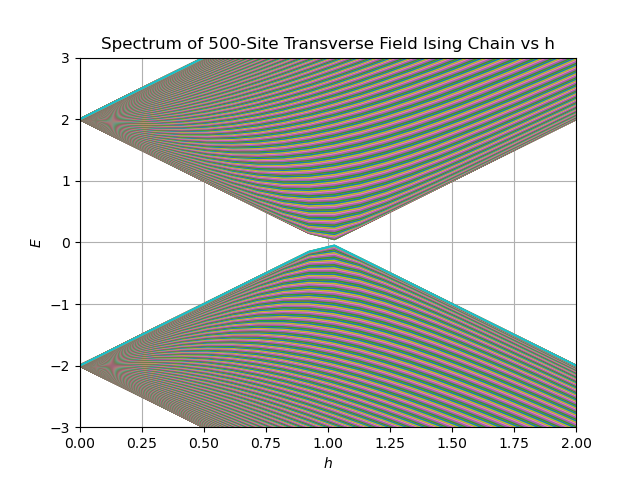

In [4]:
L=500
J=1.
kappa=1.
Hs = np.r_[0:4:40j]
ens = []
eigv = np.zeros((len(Hs), 2*L , 1), dtype=float)


for (i,h) in enumerate(Hs):
  H = Hamiltonian(h, L, J, kappa, PBC=True)
  val = H.eigensystem()
  ens.append(val[0]*2)

  
  
# We plot the spectrum.
# Zoom as you wish, if your %matplotlib notebook magic is properly working (not in Colab, apparently)
plt.figure()
plt.plot(Hs, ens, '-')
plt.title(r'Spectrum of '+str(L)+r'-Site Transverse Field Ising Chain vs h')
plt.grid()
plt.xlim((0,2))
plt.ylim((-3,3))
plt.xlabel(r'$h$')
plt.ylabel(r'$E$')


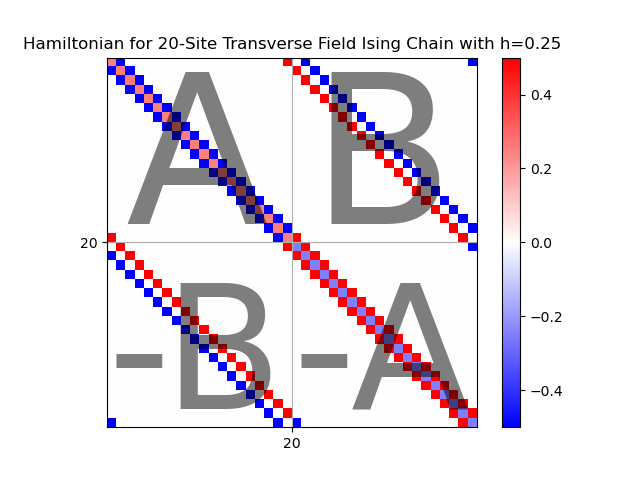

In [5]:
#Sanity Check

h = 0.25
L = 20
J = 1.
kappa = 1.

HamMatrix = Hamiltonian(h, L, J, kappa, PBC=True)
plt.figure()
plt.title(r'Hamiltonian for ' + str(L) + r'-Site Transverse Field Ising Chain with h='+ str(h))

plt.text(1.5, L-2.5, 'A', fontsize = 150, alpha=0.5 )
plt.text(L-0.5, 2*L-2.5, '-A', fontsize = 125, alpha=0.5 )
plt.text(-.5, 2*L-2.5, '-B', fontsize = 125, alpha=0.5 )
plt.text(L+1.5, L-2.5, 'B', fontsize = 150, alpha=0.5 )

plt.imshow(HamMatrix.matrix()(0),interpolation='none',cmap='bwr')
plt.colorbar()
plt.xticks([L-0.5],[L])
plt.yticks([L-0.5],[L])
plt.grid(True)
plt.show()

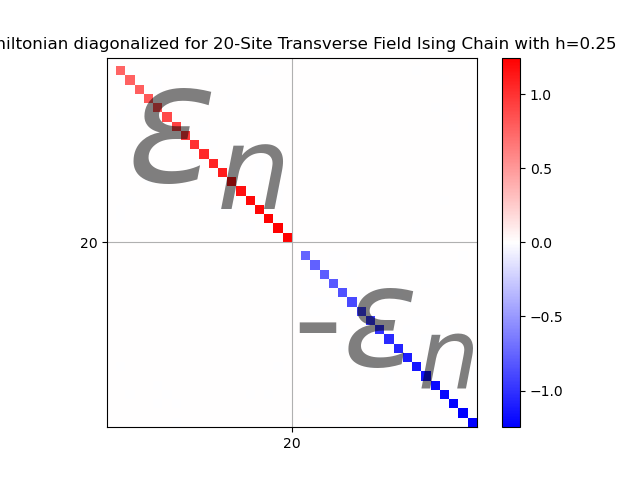

In [6]:
## Sanity Check
h = 0.25
L = 20
J = 1.
kappa = 1.

HamToDiag = Hamiltonian(h, L, J, kappa, PBC=False)
U=HamToDiag.U_matrix()
Udagger=U.conj().T
Hd=Udagger@HamToDiag.matrix()@U

plt.figure()
plt.title(r'Hamiltonian diagonalized for ' + str(L) + r'-Site Transverse Field Ising Chain with h='+ str(h))

plt.text(1.5, 0.65*L, r'$\epsilon_{n}$', fontsize = 120, alpha=0.5 )
plt.text(L-0.5, 1.65*L, r'-$\epsilon_{n}$', fontsize = 100, alpha=0.5 )

plt.imshow(Hd,interpolation='none',cmap='bwr')
plt.xticks([L-0.5],[L])
plt.yticks([L-0.5],[L])
plt.colorbar()
plt.grid(True)
plt.show()

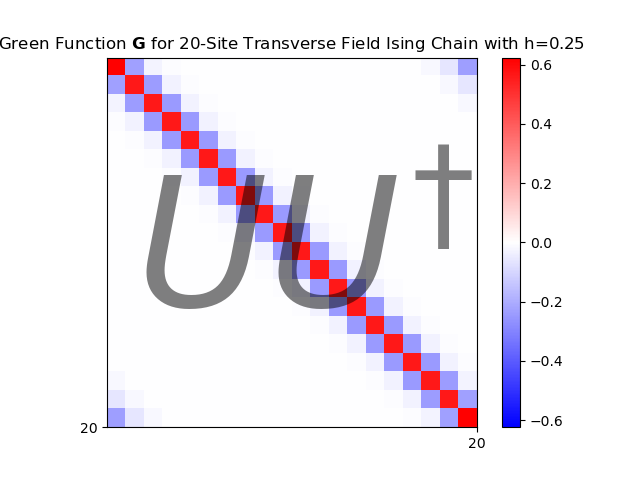

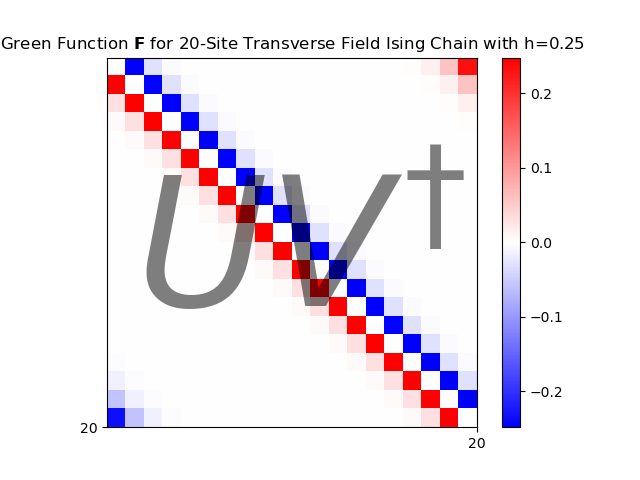

In [7]:
#Sanity Check
h = 0.25
L = 20
J = 1.
kappa = 1.

HamToGreen = Hamiltonian(h, L, J, kappa, PBC=False)

U = HamToGreen.U_matrix()
G,F=HamToGreen.greenFunc()

plt.figure()
plt.title(r'Green Function $\mathbf{G}$ for ' + str(L) + r'-Site Transverse Field Ising Chain with h='+ str(h))

plt.text(1, 0.65*L, r'$U U^{\dagger}$', fontsize = 130, alpha=0.5 )

plt.imshow(G,interpolation='none',cmap='bwr', norm=matplotlib.colors.CenteredNorm())
plt.xticks([L-0.5],[L])
plt.yticks([L-0.5],[L])
plt.colorbar()
plt.grid(True)
plt.show()




plt.figure()
plt.title(r'Green Function $\mathbf{F}$ for ' + str(L) + r'-Site Transverse Field Ising Chain with h='+ str(h))

plt.text(1, 0.65*L, r'$U V^{\dagger}$', fontsize = 130, alpha=0.5 )

plt.imshow(F,interpolation='none',cmap='bwr', norm=matplotlib.colors.CenteredNorm())
plt.xticks([L-0.5],[L])
plt.yticks([L-0.5],[L])
plt.colorbar()
plt.grid(True)
plt.show()


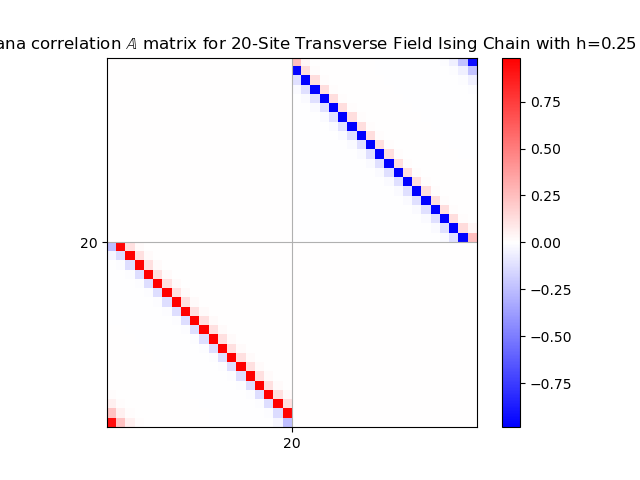

In [9]:
#Sanity Check

h = 0.25
L = 20
J = 1.
kappa = 1.

HamToEnt = Hamiltonian(h, L, J, kappa, PBC=False)

TR = np.array([[0.,1.],[0.,0.]])
BL = np.array([[0.,0.],[1.,0.]])

Id = np.eye(L)

G,F = HamToEnt.greenFunc()

A = (np.kron(TR,-Id+2*G-2*F) + np.kron(BL,Id-2*G-2*F))


plt.figure()
plt.title(r'Majorana correlation $\mathbb{A}$ matrix for ' + str(L) + r'-Site Transverse Field Ising Chain with h='+ str(h))

plt.imshow(A,interpolation='none',cmap='bwr', norm=matplotlib.colors.CenteredNorm())
plt.xticks([L-0.5],[L])
plt.yticks([L-0.5],[L])
plt.colorbar()
plt.grid(True)
plt.show()

# B = diagonalization(1j*A)

# A = B[0][L:]
# ones = lambda x: np.abs(x-1.)>10**(-4)
# S=(-1)*sum([(jj+1)/2.0*np.log((jj+1)/2.0)+(1-jj)/2.0*np.log((1-jj)/2.0) for jj in A if ones(jj)])

# print(A)
# print(S)

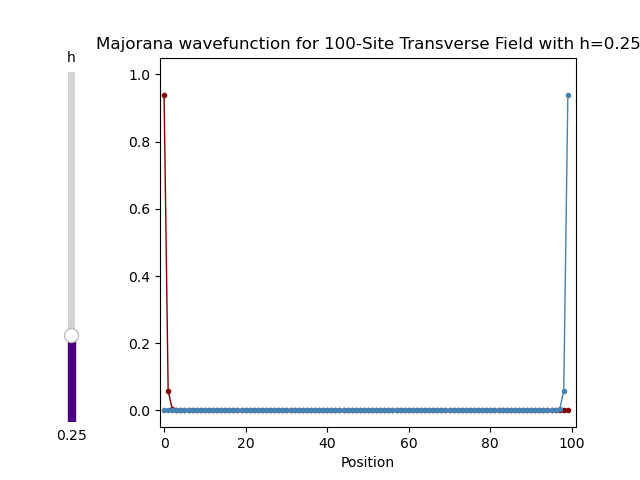

In [10]:
L = 100
J = 1.
kappa = 1.
h_init = 0.25

fig, ax = plt.subplots()
ax.set_title('Majorana wavefunction for ' + str(L) + '-Site Transverse Field with h='+ str(h_init))

line, = ax.plot(Hamiltonian(h_init, L, J, kappa, PBC=False).majorana()[0],'o-', lw=1, color='maroon', markersize=3)
line1, = ax.plot(Hamiltonian(h_init, L, J, kappa, PBC=False).majorana()[1],'o-', lw=1, color='steelblue', markersize=3)
ax.set_xlabel('Position')

ax.set_xlim((-1,L+1))
ax.set_ylim((-0.05,1.05))

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25)


axh = fig.add_axes([0.1, 0.12 , 0.0225, 0.73])
h_slider = Slider(
    ax=axh,
    label="h",
    valmin=0,
    valmax=1,
    valinit=h_init,
    orientation="vertical",
    color='indigo'
)

def update(val):
    line.set_ydata(Hamiltonian(h_slider.val, L, J, kappa, PBC=False).majorana()[0])
    line1.set_ydata(Hamiltonian(h_slider.val, L, J, kappa, PBC=False).majorana()[1])
    ax.set_title('Majorana wavefunction for ' + str(L) + '-Site Transverse Field with h='+ str(round(h_slider.val,2)))
    fig.canvas.draw_idle()

h_slider.on_changed(update)


plt.show()  

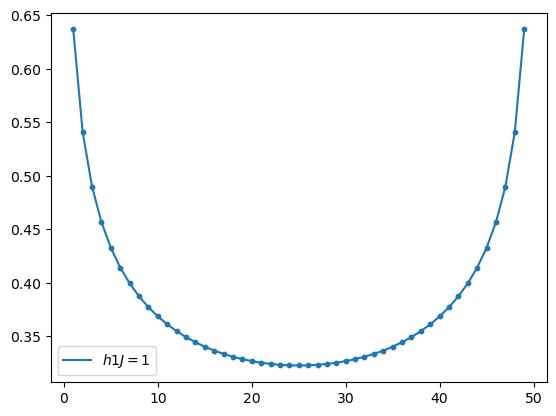

In [9]:
## Correlations:

L=50
h=1
J=1
plt.figure()
corr=[0 for i in range(L)]
H = Hamiltonian(h,L,J,1,PBC=True)
for l in range(L):
    corr[l]=H.spincorr(0,l)(0)
    
plt.scatter(range(1,L),corr[1:],s=10)
plt.plot(range(1,L),corr[1:],label=r"$h$"+str(h)+"$J=$"+str(J))
plt.legend()

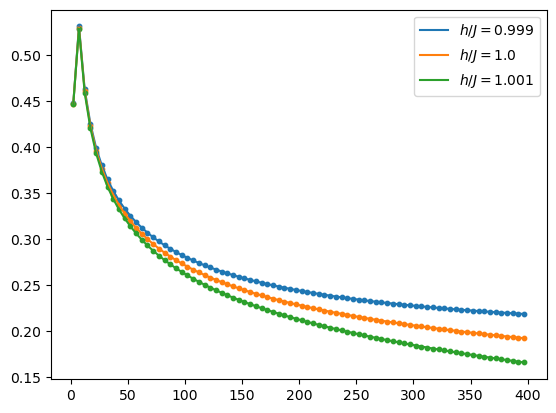

In [10]:
## Correlations:
L=[i for i in range(2,400,5)]
jh=[0.999, 1.0,1.001]

plt.figure()
for h in jh:
    corr=[0 for i in range(len(L))]
    for l in range(len(L)):
        H = Hamiltonian(h,L[l],1,1,PBC=True)
        corr[l]=H.spincorr(0,int(L[l]/2))(0)
    plt.scatter(L,corr,s=10)
    plt.plot(L,corr,label=r"$h/J=$"+str(h))
plt.legend()


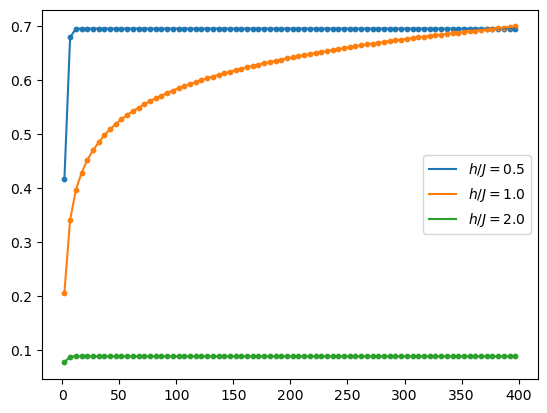

In [11]:
# Entropy
L=[i for i in range(2,400,5)]
jh=[0.5, 1.0,2.0]

plt.figure()
for h in jh:
    corr=[0 for i in range(len(L))]
    for l in range(len(L)):
        H = Hamiltonian(h,L[l],1,1,PBC=False)
        corr[l]=H.entropy_ent(int(L[l]/2.0))
    plt.scatter(L,corr,s=10)
    plt.plot(L,corr,label=r"$h/J=$"+str(h))
plt.legend()


In [11]:
dir(Hamiltonian)

['Mmat',
 'U_matrix',
 '_Hamiltonian__zero_subspace',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'eigensystem',
 'entropy_ent',
 'greenFunc',
 'majorana',
 'matrix',
 'spincorr']

In [13]:
help(Hamiltonian.spincorr)

Help on function spincorr in module __main__:

spincorr(self, i: int, j: int, M=None)
    If PBC is true then this returns a lambda function object.spincorr()(p) where
    for each p one obtains the spin correlation for that parity, but in PBC False this returns only one matrix.
    
    This corresponds to C_{i,j}^{xx} = <sigma^x_{i} sigma^x_{j}>

